**GIVE ME SOME CREDIT**

INTRODUCTION:
This project uses a [ Kaggle Dataset](https://www.kaggle.com/c/GiveMeSomeCredit) about credit repayment difficulty rates among customers. The datset contains history of approx. 250,000 customers in which it was divided between training and test dataset.

OBJECTIVE:
Tha aim is to improve on the state of the art in credit scoring by predicting the probability that customer will experience financial distress in the next two years given his record present in the dataset.

**DATASET VARIABLES:** 

**SeriousDlqin2yrs (Target variable)** : Person experienced 90 days past due delinquency or worse.

It is the target variable (label)

**RevolvingUtilizationOfUnsecuredLines** : Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits

**age** : Age of borrower in years

**NumberOfTime30-59DaysPastDueNotWorse** : Number of times borrower has been 30-59 days past due but no worse in the last 2 years

**DebtRatio** : Monthly debt payments, alimony,living costs divided by monthy gross income

**MonthlyIncome** : Monthly income

**NumberOfOpenCreditLinesAndLoans** : Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)

**NumberOfTimes90DaysLate** : Number of times borrower has been 90 days or more past due

**NumberRealEstateLoansOrLines** : Number of mortgage and real estate loans including home equity lines of credit

**NumberOfTime60-89DaysPastDueNotWorse** : Number of times borrower has been 60-89 days past due but no worse in the last 2 years

**NumberOfDependents** : Number of dependents in family excluding themselves (spouse, children etc.)



In [1]:
#Importing required libraries
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=Warning)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

from collections import Counter
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, roc_curve, auc, classification_report, recall_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy import stats, special
import lightgbm as lgb
import xgboost as xgs



In [2]:
#Training dataset
TrainData = pd.read_csv('/content/drive/MyDrive/GiveMeSomeCredit/cs-training.csv')

**EXPLORING DATA ANALYSIS:** Understanding data and business around it


In [3]:
TrainData.shape

(150000, 12)

In [4]:
TrainData.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [5]:
TrainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [6]:
TrainData.isnull().sum()

Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [7]:
#Test dataset
TestData = pd.read_csv('/content/drive/MyDrive/GiveMeSomeCredit/cs-test.csv')
TestData.shape

(101503, 12)

In [8]:
TestData.isnull().sum()

Unnamed: 0                                   0
SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                            20103
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60-89DaysPastDueNotWorse         0
NumberOfDependents                        2626
dtype: int64

**Observations:**

*   There are 150,000 rows for 11 features in our training data and test data contains total 11 features with 101,503 rows (The column Unnamed: 0 will have no significance in the predictive modelling because it represents ID of the customer).
*   We see in both the training  and test data, that all the datatypes belong to a numeric class i.e. int and float.
*   In both training and test datasets columns MonthlyIncome and NumberOfDependents have some null values. First we have to either impute these values or remove the missing values data. Here we are replacing the missing values with the median in 'MonthlyIncome' column after removing the outliers in training dataset if any, and with 0 in 'NumberOfdependents' column.

Let's create a copy of our two datasets, so the changes we are gonna make forward does not affect the original data.

In [9]:
train_df = TrainData.copy()
test_df = TestData.copy()

Since, we need to predict the probability of Delinquency in the test data, we need to remove the additional column from it first.

In [10]:
test_df.drop('SeriousDlqin2yrs', axis=1, inplace = True)

Also as mentioned above, let's take the ID column i.e. Unnamed: 0 and store it in seperate variables.

In [11]:
trainID = train_df['Unnamed: 0']
testID = test_df['Unnamed: 0']

train_df.drop('Unnamed: 0', axis=1, inplace=True)
test_df.drop('Unnamed: 0', axis=1, inplace=True)

**Imbalance Ratio:**

Since we have a total training data of 150,000 rows there are high chances that it can be an imbalanced dataset. Therefore, checking the positive and negative delinquency ratio.

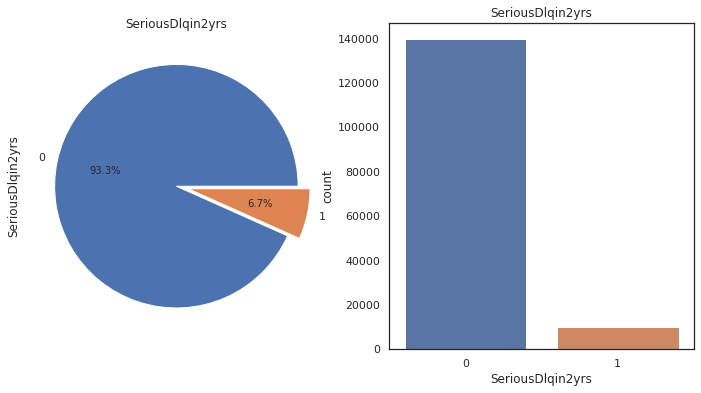

In [12]:
fig, axes = plt.subplots(1,2,figsize=(12,6))
train_df['SeriousDlqin2yrs'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=axes[0])
axes[0].set_title('SeriousDlqin2yrs')
#ax[0].set_ylabel('')
sns.countplot('SeriousDlqin2yrs', data=train_df, ax=axes[1])
axes[1].set_title('SeriousDlqin2yrs')
plt.show()

The ratio of negative to positive delinquency outliers are found to be 93.3% to 6.7%, which is approximately a ratio of 14:1. Therefore, our dataset is highly imbalanced. We cannot rely on the accuracy scores to predict the model's success. Other evaluation metrics would be better to consider in this case.

Now let's move on the Outlier Analysis section of our EDA. Here we will remove potential outliers which might affect our predictive modelling.

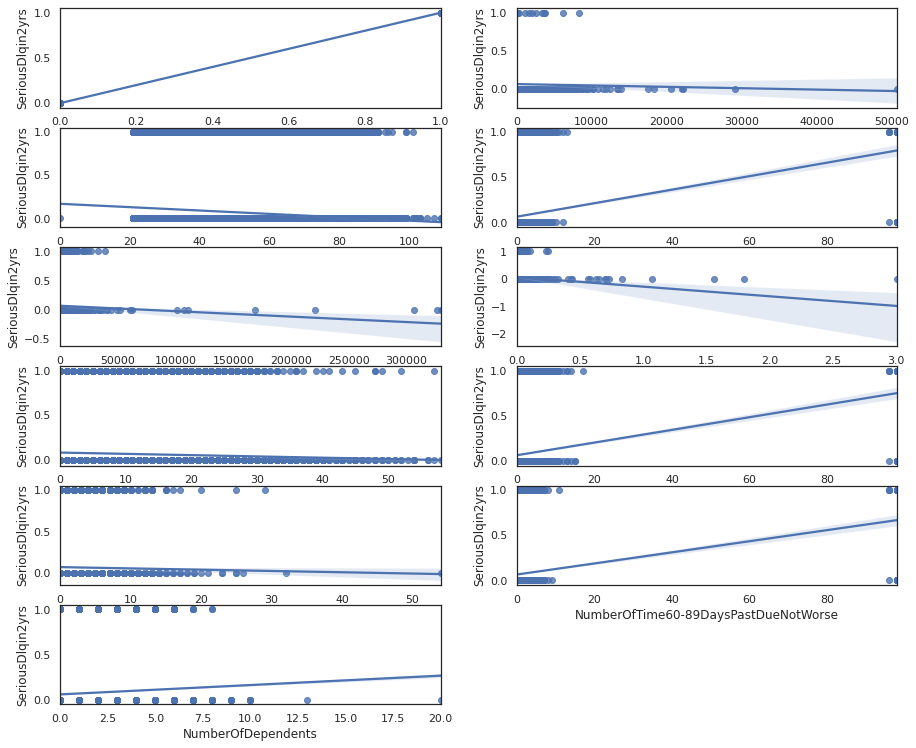

In [13]:
#Reg plot

fig = plt.figure(figsize=[15,15])
for col,i in zip(train_df.columns, range(1,13)):
    axes = fig.add_subplot(7,2,i)
    sns.regplot(train_df[col],train_df.SeriousDlqin2yrs,ax=axes)
plt.show()

In [14]:
# #Boxplot

# fig = plt.figure(figsize=[10,10])
# for col, i in zip(train_df.columns, range(1,13)):
#     axes = fig.add_subplot(7,2,i)
#     sns.boxplot(train_df[col], train_df.SeriousDlqin2yrs, ax=axes)
# plt.show()

From the above graphs we can clearly see the presence of outliers:

*   In the columns 'NumberOfTime30-59DaysPastDueNotWorse' ,'NumberOfTime60-89DaysPastDueNotWorse' and 'NumberOfTimes90DaysLate', we see delinquency range beyond 90 which is common across all 3 features.

*   There are some unusually high values for 'DebtRatio' and 'RevolvingUtilizationOfUnsecuredLines'.

Step 1: Fixing the columns 'NumberOfTime30-59DaysPastDueNotWorse' , 'NumberOfTime60-89DaysPastDueNotWorse' and 'NumberOfTimes90DaysLate'.


In [15]:
print("Unique values in 30-59Days", np.unique(train_df['NumberOfTime30-59DaysPastDueNotWorse']))
print("Unique values in 60-89Days", np.unique(train_df['NumberOfTime60-89DaysPastDueNotWorse']))
print("Unique values in 90Days", np.unique(train_df['NumberOfTimes90DaysLate']))

Unique values in 30-59Days [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 96 98]
Unique values in 60-89Days [ 0  1  2  3  4  5  6  7  8  9 11 96 98]
Unique values in 90Days [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 96 98]


In [16]:
print("Unique values in '30-59 Days' values that are more than or equal to 90:",np.unique(train_df[train_df['NumberOfTime30-59DaysPastDueNotWorse']>=90]
                                                                                          ['NumberOfTime30-59DaysPastDueNotWorse']))
print("Unique values in '60-89 Days' when '30-59 Days' values are more than or equal to 90:",np.unique(train_df[train_df['NumberOfTime30-59DaysPastDueNotWorse']>=90]
                                                                                                       ['NumberOfTime60-89DaysPastDueNotWorse']))
print("Unique values in '90 Days' when '30-59 Days' values are more than or equal to 90:",np.unique(train_df[train_df['NumberOfTime30-59DaysPastDueNotWorse']>=90]
                                                                                                    ['NumberOfTimes90DaysLate']))
print("Proportion of positive class with special 96/98 values:",
      round(train_df[train_df['NumberOfTime30-59DaysPastDueNotWorse']>=90]['SeriousDlqin2yrs'].sum()*100/
      len(train_df[train_df['NumberOfTime30-59DaysPastDueNotWorse']>=90]['SeriousDlqin2yrs']),2),'%')

Unique values in '30-59 Days' values that are more than or equal to 90: [96 98]
Unique values in '60-89 Days' when '30-59 Days' values are more than or equal to 90: [96 98]
Unique values in '90 Days' when '30-59 Days' values are more than or equal to 90: [96 98]
Proportion of positive class with special 96/98 values: 54.65 %


These 96 and 98 values can be viewed as accounting errors. Hence, we would replace them with the maximum value before 96 i.e. 13, 11 and 17.

In [17]:
train_df.loc[train_df['NumberOfTime30-59DaysPastDueNotWorse'] >= 90, 'NumberOfTime30-59DaysPastDueNotWorse'] = 13
train_df.loc[train_df['NumberOfTime60-89DaysPastDueNotWorse'] >= 90, 'NumberOfTime60-89DaysPastDueNotWorse'] = 11
train_df.loc[train_df['NumberOfTimes90DaysLate'] >= 90, 'NumberOfTimes90DaysLate'] = 17

In [18]:
print("Unique values in 30-59Days", np.unique(train_df['NumberOfTime30-59DaysPastDueNotWorse']))
print("Unique values in 60-89Days", np.unique(train_df['NumberOfTime60-89DaysPastDueNotWorse']))
print("Unique values in 90Days", np.unique(train_df['NumberOfTimes90DaysLate']))

Unique values in 30-59Days [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Unique values in 60-89Days [ 0  1  2  3  4  5  6  7  8  9 11]
Unique values in 90Days [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17]


Performing a similar analysis on the Test Set

In [19]:
print("Unique values in '30-59 Days' values that are more than or equal to 90:",np.unique(test_df[test_df['NumberOfTime30-59DaysPastDueNotWorse']>=90]
                                                                                          ['NumberOfTime30-59DaysPastDueNotWorse']))
print("Unique values in '60-89 Days' when '30-59 Days' values are more than or equal to 90:",np.unique(test_df[test_df['NumberOfTime30-59DaysPastDueNotWorse']>=90]
                                                                                                       ['NumberOfTime60-89DaysPastDueNotWorse']))
print("Unique values in '90 Days' when '30-59 Days' values are more than or equal to 90:",np.unique(test_df[test_df['NumberOfTime30-59DaysPastDueNotWorse']>=90]
                                                                                                    ['NumberOfTimes90DaysLate']))
print("Unique values in '60-89 Days' when '30-59 Days' values are less than 90:",np.unique(test_df[test_df['NumberOfTime30-59DaysPastDueNotWorse']<90]
                                                                                           ['NumberOfTime60-89DaysPastDueNotWorse']))
print("Unique values in '90 Days' when '30-59 Days' values are less than 90:",np.unique(test_df[test_df['NumberOfTime30-59DaysPastDueNotWorse']<90]
                                                                                        ['NumberOfTimes90DaysLate']))

Unique values in '30-59 Days' values that are more than or equal to 90: [96 98]
Unique values in '60-89 Days' when '30-59 Days' values are more than or equal to 90: [96 98]
Unique values in '90 Days' when '30-59 Days' values are more than or equal to 90: [96 98]
Unique values in '60-89 Days' when '30-59 Days' values are less than 90: [0 1 2 3 4 5 6 7 8 9]
Unique values in '90 Days' when '30-59 Days' values are less than 90: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 16 17 18]


Since, these values exist in Test Set as well. Therefore, replacing them with maximum values before 96 and 98 i.e. 19, 9 and 18.

In [20]:
test_df.loc[test_df['NumberOfTime30-59DaysPastDueNotWorse'] >= 90, 'NumberOfTime30-59DaysPastDueNotWorse'] = 19
test_df.loc[test_df['NumberOfTime60-89DaysPastDueNotWorse'] >= 90, 'NumberOfTime60-89DaysPastDueNotWorse'] = 9
test_df.loc[test_df['NumberOfTimes90DaysLate'] >= 90, 'NumberOfTimes90DaysLate'] = 18

print("Unique values in 30-59Days", np.unique(test_df['NumberOfTime30-59DaysPastDueNotWorse']))
print("Unique values in 60-89Days", np.unique(test_df['NumberOfTime60-89DaysPastDueNotWorse']))
print("Unique values in 90Days", np.unique(test_df['NumberOfTimes90DaysLate']))

Unique values in 30-59Days [ 0  1  2  3  4  5  6  7  8  9 10 11 12 19]
Unique values in 60-89Days [0 1 2 3 4 5 6 7 8 9]
Unique values in 90Days [ 0  1  2  3  4  5  6  7  8  9 10 11 12 16 17 18]


Step 2: Checking for 'DebtRatio' and 'RevolvingUtilizationOfUnsecuredLines'.

In [21]:
print('Debt Ratio: \n',train_df['DebtRatio'].describe())
print('\nRevolving Utilization of Unsecured Lines: \n',train_df['RevolvingUtilizationOfUnsecuredLines'].describe())

Debt Ratio: 
 count    150000.000000
mean        353.005076
std        2037.818523
min           0.000000
25%           0.175074
50%           0.366508
75%           0.868254
max      329664.000000
Name: DebtRatio, dtype: float64

Revolving Utilization of Unsecured Lines: 
 count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64


Here you can see a massive difference between the 75th Quantile and the Max Value. Let's explore this in a greater depth.

In [22]:
quantiles = [0.75,0.8,0.81,0.85,0.9,0.95,0.975,0.99]

for i in quantiles:
    print(i*100,'% quantile of debt ratio is: ',train_df.DebtRatio.quantile(i))

75.0 % quantile of debt ratio is:  0.86825377325
80.0 % quantile of debt ratio is:  4.0
81.0 % quantile of debt ratio is:  14.0
85.0 % quantile of debt ratio is:  269.1499999999942
90.0 % quantile of debt ratio is:  1267.0
95.0 % quantile of debt ratio is:  2449.0
97.5 % quantile of debt ratio is:  3489.024999999994
99.0 % quantile of debt ratio is:  4979.040000000037


As you can see there is a huge rise in quantile post 81%. So, our main aim would be to check the potential outliers beyond 81% quantiles. However, since our data is 150,000, let's consider 95% and 97.5% quantiles for our further analysis.

In [23]:
train_df[train_df['DebtRatio'] >= train_df['DebtRatio'].quantile(0.95)][['SeriousDlqin2yrs','MonthlyIncome']].describe()

,SeriousDlqin2yrs,MonthlyIncome
count,7501.000000,379.000000
mean,0.055193,0.084433
std,0.228371,0.278403
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


**Observations:**

Out of 7501 customers who have debt ratio greater than 95% i.e. the number of times their debt is higher than their income, only 379 have Monthly Income values.

The Max for Monthly Income is 1 and Min is 0 which makes us wonder that are data entry errors. Let's check whether the Serious Delinquency in 2 years and Monthly Income values are equal.

In [24]:
train_df[(train_df["DebtRatio"] > train_df["DebtRatio"].quantile(0.95)) & (train_df['SeriousDlqin2yrs'] == train_df['MonthlyIncome'])]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
50,0,0.818978,73,0,3095.0,0.0,9,0,1,1,0.0
73,0,0.059669,31,0,3162.0,0.0,11,0,2,0,1.0
90,0,0.039388,51,0,15466.0,0.0,7,0,0,0,0.0
326,0,0.013115,43,0,4211.0,0.0,21,0,2,0,2.0
508,0,1.000000,73,0,8500.0,0.0,2,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
147523,0,0.666509,50,0,4351.0,0.0,12,0,2,0,2.0
148258,0,0.211955,31,0,2734.0,0.0,9,0,1,0,1.0
148432,0,0.091785,37,0,2752.0,0.0,7,0,2,0,3.0
149383,0,0.239302,63,0,3153.0,0.0,29,0,1,0,0.0


Hence, our suspects are true and there are 331 out of 379 rows where Monthly Income is equal to the Serious Delinquencies in 2 years. Hence we will remove these 331 outliers from our analysis as their current values aren't useful for our predictive modelling and will add to the bias and variance.

The reason behind this, is we have 331 rows where the debt ratio is massive compared to the customer's income and they arent't scrutinized for defaulting which is nothing but a data entry error.

In [25]:
train_df = train_df[-((train_df["DebtRatio"] > train_df["DebtRatio"].quantile(0.95)) & (train_df['SeriousDlqin2yrs'] == train_df['MonthlyIncome']))]
train_df

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


**Revolving Utilization of Unsecured Lines**

This field basically represents the ratio of the amount owed by the credit limit of a customer. A ratio higher than 1 is considered to be a serious defaulter. A Ratio of 10 functionally also seems possible, let's see how many of these customers have the Revolving Utilization of Unsecured Lines greater than 10.

In [26]:
train_df[train_df['RevolvingUtilizationOfUnsecuredLines']>10].describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,241.000000,241.000000,241.000000,241.000000,241.000000,173.00000,241.000000,241.000000,241.000000,241.000000,228.000000
mean,0.070539,3564.023932,50.630705,0.186722,571.918644,8467.67052,5.763485,0.074689,1.186722,0.087137,0.688596
std,0.256587,5123.802683,14.565389,0.579502,1772.948412,6564.06825,3.114160,0.579711,1.065750,0.559651,1.038659
min,0.000000,11.385230,24.000000,0.000000,0.000800,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,941.000000,39.000000,0.000000,0.217813,4500.00000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2012.000000,48.000000,0.000000,0.402560,7000.00000,5.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,4116.000000,62.000000,0.000000,59.000000,10091.00000,7.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,87.000000,3.000000,21395.000000,44472.00000,21.000000,8.000000,9.000000,7.000000,4.000000


Here if you see the difference between the 50th and 75 quantile for Revolving Utilization of Unsecured Lines, you'll observe that there is a massive increase from 13 to 1891.25. Since 13 seems like a reasonable ratio too (but way too high), let's check how many of these counts lie above 13.

In [27]:
train_df[train_df['RevolvingUtilizationOfUnsecuredLines']>13].describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,238.000000,238.000000,238.000000,238.000000,238.000000,170.000000,238.000000,238.000000,238.000000,238.000000,225.000000
mean,0.058824,3608.797826,50.634454,0.163866,579.117900,8520.041176,5.689076,0.071429,1.176471,0.071429,0.693333
std,0.235790,5140.423232,14.617658,0.522123,1782.962163,6606.889618,3.032170,0.580214,1.064558,0.542637,1.043346
min,0.000000,14.000000,24.000000,0.000000,0.000800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,951.000000,39.000000,0.000000,0.216587,4608.000000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2023.500000,48.000000,0.000000,0.391176,7000.000000,5.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,4128.750000,62.000000,0.000000,82.250000,10178.750000,7.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,87.000000,3.000000,21395.000000,44472.000000,21.000000,8.000000,9.000000,7.000000,4.000000


Despite owing thousands, these 238 people do not show any default which means this might be another error. Even if it is not an error, these numbers will add huge bias and variance to our final predictions. Therefore, the best decision is to remove these values.

In [28]:
train_df = train_df[train_df['RevolvingUtilizationOfUnsecuredLines']<=13]
train_df

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


The outliers are now handled. Next, we will move on to handling the missing data, as we observed at the start of this notebook that MonthlyIncome and NumberOfDependents had null values.

**Null Handling**

Since MonthlyIncome is an integer value, we will replace the nulls with the median values.

Number of Dependents can be characterized as a categorical variable, hence if customers have NA for number of dependents, it means that they do not have any dependents. Therefore, we fill them with zeros.



In [29]:
def MissingHandler(df):
    DataMissing = df.isnull().sum()*100/len(df)
    DataMissingByColumn = pd.DataFrame({'Percentage Nulls':DataMissing})
    DataMissingByColumn.sort_values(by='Percentage Nulls',ascending=False,inplace=True)
    return DataMissingByColumn[DataMissingByColumn['Percentage Nulls']>0]

MissingHandler(train_df)

,Percentage Nulls
MonthlyIncome,19.850633
NumberOfDependents,2.617261


Therefore, we have 19.76% and 2.59% Nulls for MonthlyIncome and NumberOfDependents respectively.

In [30]:
train_df['MonthlyIncome'].fillna(train_df['MonthlyIncome'].median(), inplace=True)
train_df['NumberOfDependents'].fillna(0, inplace = True)

Rechecking Nulls

In [31]:
MissingHandler(train_df)

,Percentage Nulls


Applying Similar Analysis for the Testing Data

In [32]:
MissingHandler(test_df)

,Percentage Nulls
MonthlyIncome,19.805326
NumberOfDependents,2.587116


Similar to the training data, we have 19.71% and 2.56% nulls for MonthlyIncome and NumberOfDependents respectively.

In [33]:
test_df['MonthlyIncome'].fillna(test_df['MonthlyIncome'].median(), inplace=True)
test_df['NumberOfDependents'].fillna(0, inplace = True)

Rechecking Nulls

In [34]:
MissingHandler(test_df)

,Percentage Nulls


In [35]:
print(train_df.shape)
print(test_df.shape)

(149431, 11)
(101503, 10)


**Additional EDA**

Let's study a few more things about the dataset to get more familiar with it.

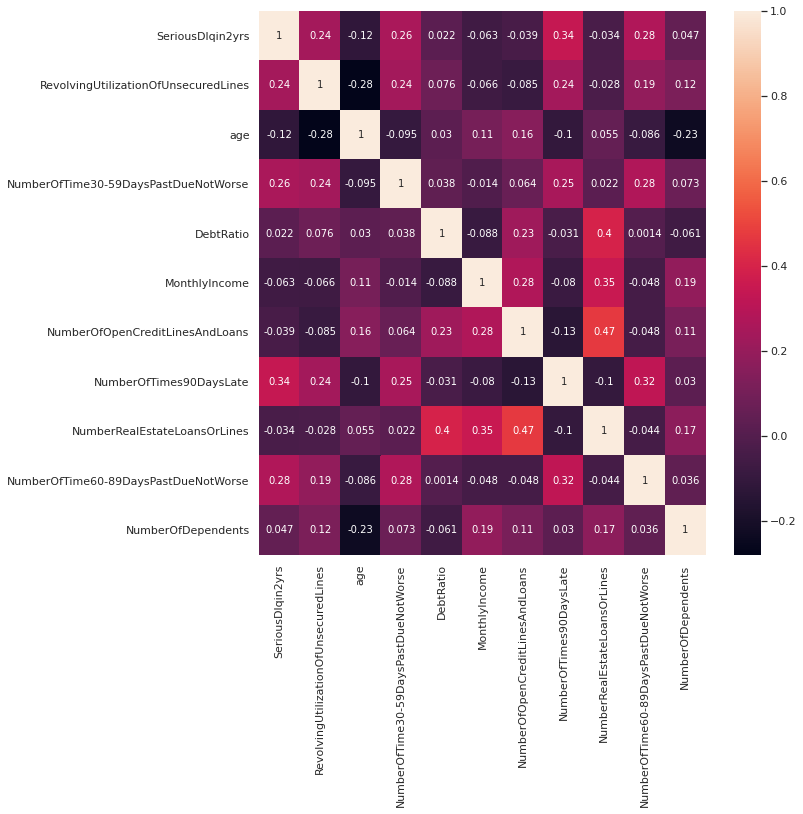

In [36]:
# Correlation matrix
corr_mtx = train_df.corr(method='spearman')
        
plt.figure(figsize = (10,10))

sns.heatmap(corr_mtx, xticklabels=corr_mtx.columns, yticklabels=corr_mtx.columns, annot=True)
plt.show()

From the correlation heatmap above, we can see the most correlated values to SeriousDlqin2yrs are NumberOfTime30-59DaysPastDueNotWorse , NumberOfTime60-89DaysPastDueNotWorse and NumberOfTimes90DaysLate.



**FEATURE ENGINEERING**

Let's first combine the train and test sets to add features on both the data and conduct further analyses. We will split them later before Model Testing.

In [37]:
SeriousDlqIn2Yrs = train_df['SeriousDlqin2yrs']

train_df.drop('SeriousDlqin2yrs', axis = 1 , inplace = True)

In [38]:
finalData = pd.concat([train_df, test_df])

finalData.shape

(250934, 10)

Adding some new features:

MonthlyIncomePerPerson: Monthly Income divided by the number of dependents

MonthlyDebt: Monthly Income multiplied by the Debt Ratio

isRetired: Person whose monthly income is 0 and age is greater than 65 (Assumed Retirement Age)

RevolvingLines: Difference between Number of Open Credit Lines and Loans and Number of Real Estate Lines and Loans

hasRevolvingLines: If RevolvingLines exists then 1 else 0

hasMultipleRealEstates: If the Number of Real Estates is greater than 2

incomeDivByThousand: Monthly Income divided by 1000. Fraud might be more likely for these or it might signal the person is in a new job and hasn’t had a percent raise in pay yet. Both groups signal higher risk.

In [39]:
#New Features
finalData['MonthlyIncomePerPerson'] = finalData['MonthlyIncome']/(finalData['NumberOfDependents']+1)
finalData['MonthlyIncomePerPerson'].fillna(0, inplace=True)

finalData['MonthlyDebt'] = finalData['MonthlyIncome']*finalData['DebtRatio']
finalData['MonthlyDebt'].fillna(finalData['DebtRatio'],inplace=True)
finalData['MonthlyDebt'] = np.where(finalData['MonthlyDebt']==0, finalData['DebtRatio'],finalData['MonthlyDebt'])

finalData['isRetired'] = np.where((finalData['age'] > 65), 1, 0)
finalData['RevolvingLines'] = finalData['NumberOfOpenCreditLinesAndLoans']-finalData['NumberRealEstateLoansOrLines']

finalData['hasRevolvingLines']=np.where((finalData['RevolvingLines']>0),1,0)

finalData['hasMultipleRealEstates'] = np.where((finalData['NumberRealEstateLoansOrLines']>=2),1,0)

finalData['incomeDivByThousand'] = finalData['MonthlyIncome']/1000

In [40]:
finalData.shape

(250934, 17)

In [41]:
#Verifying null/missing values
MissingHandler(finalData)

,Percentage Nulls


We have now added new features to our dataset. Next, we will perform a skewness check on our data by analysing the distributions of individual columns and perform Box Cox Transformation to reduce the skewness.

**Skewness Check and Box Cox Transformation**

Let's check the distribution of each values first

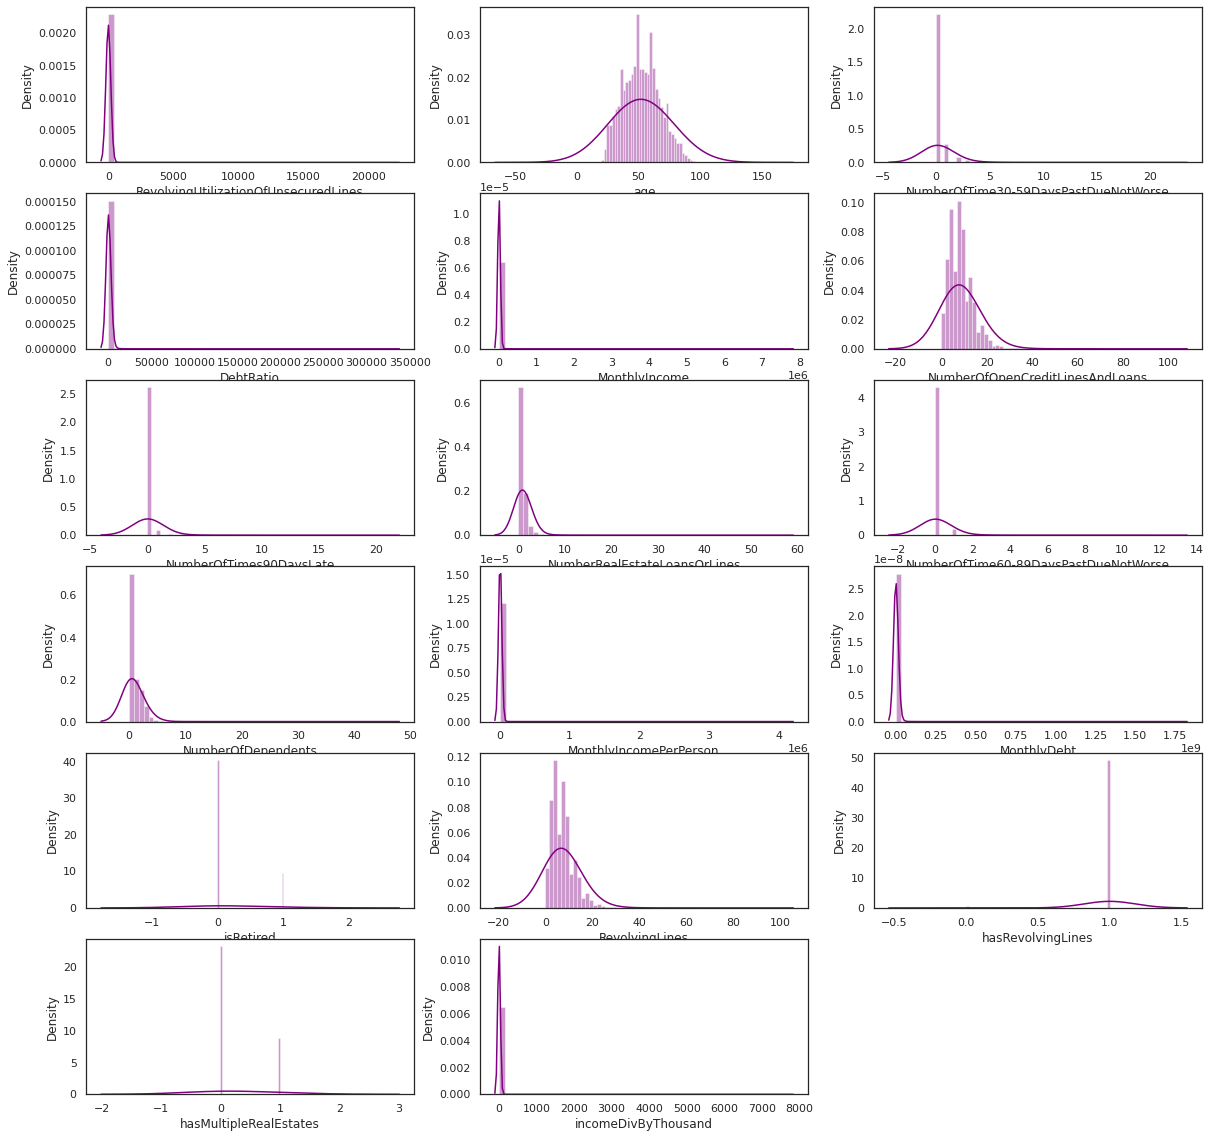

In [42]:
columnList = list(finalData.columns)
columnList

fig = plt.figure(figsize=[20,20])
for col,i in zip(columnList,range(1,19)):
    axes = fig.add_subplot(6,3,i)
    sns.distplot(finalData[col],ax=axes, kde_kws={'bw':1.5}, color='purple')
plt.show()

From the above distribution plots, we can see that majority of our data is skewed in either of the directions. We can only see Age forming close to normal distribution. Let's check the skewness values of each column.

In [43]:
def SkewMeasure(df):
    nonObjectColList = df.dtypes[df.dtypes != 'object'].index
    skewM = df[nonObjectColList].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending = False)
    skewM=pd.DataFrame({'skew':skewM})
    return skewM[abs(skewM)>0.5].dropna()

skewM = SkewMeasure(finalData)
skewM

,skew
MonthlyIncome,218.270205
incomeDivByThousand,218.270205
MonthlyIncomePerPerson,206.221804
MonthlyDebt,98.604981
DebtRatio,92.819627
RevolvingUtilizationOfUnsecuredLines,91.721780
NumberOfTimes90DaysLate,15.097509
NumberOfTime60-89DaysPastDueNotWorse,13.509677
NumberOfTime30-59DaysPastDueNotWorse,9.773995
NumberRealEstateLoansOrLines,3.217055


The Skewness is massively high for all the columns. We would apply Box Cox Transformation with λ = 0.15 in order to reduce this skewness.

In [44]:
for i in skewM.index:
    finalData[i] = special.boxcox1p(finalData[i],0.15) #lambda = 0.15
    
SkewMeasure(finalData)

,skew
RevolvingUtilizationOfUnsecuredLines,23.234640
NumberOfTimes90DaysLate,6.787000
NumberOfTime60-89DaysPastDueNotWorse,6.602180
NumberOfTime30-59DaysPastDueNotWorse,3.212010
DebtRatio,1.958314
MonthlyDebt,1.817649
isRetired,1.564456
hasMultipleRealEstates,1.008475
NumberOfDependents,0.947591
incomeDivByThousand,0.708168


The Skewness have reduced on a much higher scale now that the Box Cox Transformation is applied. Let's check the distribution plots for individual columns again.

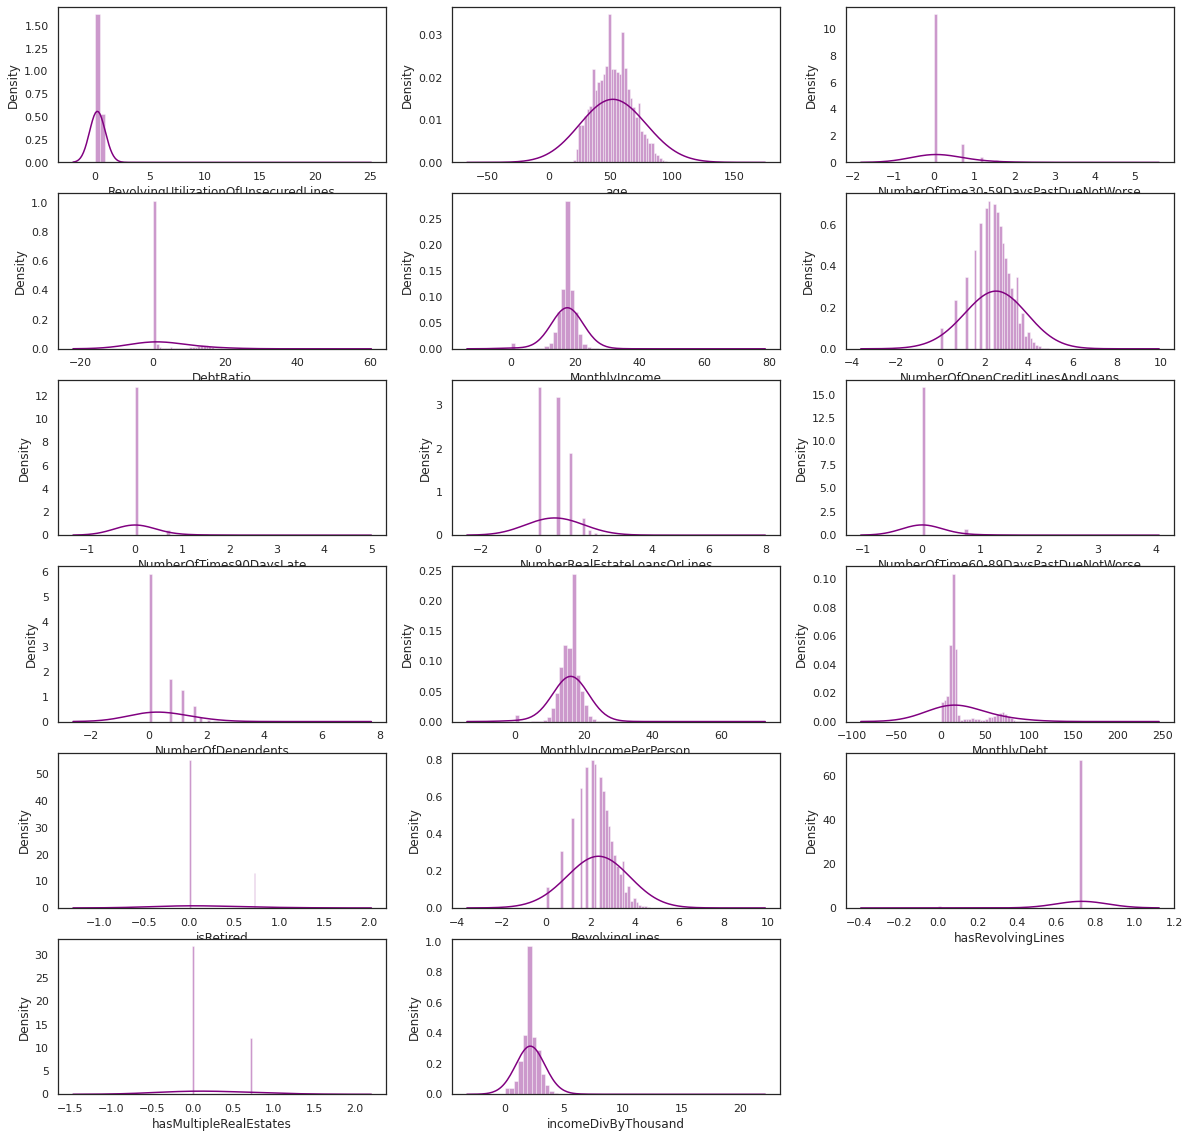

In [45]:
fig = plt.figure(figsize=[20,20])
for col,i in zip(columnList,range(1,19)):
    axes = fig.add_subplot(6,3,i)
    sns.distplot(finalData[col],ax=axes, kde_kws={'bw':1.5}, color='purple')
plt.show()

As you can see, our graphs look much better now.

**Model Training¶**

***Train-Validation Split***

We will split the train and validation sets into a 70-30 proportion.

In [46]:
trainDF = finalData[:len(train_df)]
testDF = finalData[len(train_df):]
print(trainDF.shape)
print(testDF.shape)

(149431, 17)
(101503, 17)


In [47]:
X_train, X_test, y_train, y_test = train_test_split(trainDF.to_numpy(),SeriousDlqIn2Yrs.to_numpy(), test_size=0.3, random_state=2020)

In [48]:
scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train) 
X_test_scaled = scaler.transform(X_test)

**1. LOGISTIC REGRESSION**



In [49]:
logit = LogisticRegression(random_state=42)
l_model = logit.fit(X_train_scaled, y_train)

In [50]:
logit_scores_proba  = l_model.predict_proba(X_test_scaled)
logit_scores = logit_scores_proba[:,1]

0.8549239923347166


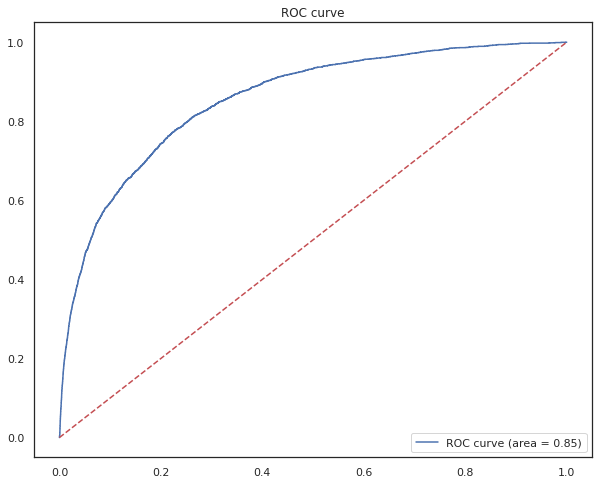

In [51]:
def plot_roc(y_test, y_predict):
    fpr, tpr, _ = roc_curve(y_test, y_predict)
    roc_auc = auc(fpr,tpr)
    print(roc_auc)
    plt.figure(figsize=(10,8))
    plt.title("ROC curve")
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0,1], [0,1],'r--')
    plt.legend(loc="lower right")
plot_roc(y_test, logit_scores)

**2. RANDOM FOREST**

In [52]:
random_forest = RandomForestClassifier()
param_grid={
    "n_estimators":[9,18,27,36,100],
    "max_depth":[5,7,9],
    "min_samples_leaf":[2,4,6,8]
}
rf_model = RandomizedSearchCV(random_forest, param_distributions = param_grid, cv=5)
rf_model.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [53]:
rf_model.best_params_

{'max_depth': 9, 'min_samples_leaf': 4, 'n_estimators': 27}

In [54]:
best_est_rf = rf_model.best_estimator_
best_est_rf.fit(X_train, y_train)
y_pred_rf = best_est_rf.predict_proba(X_test)[:,1]

0.865469837777856


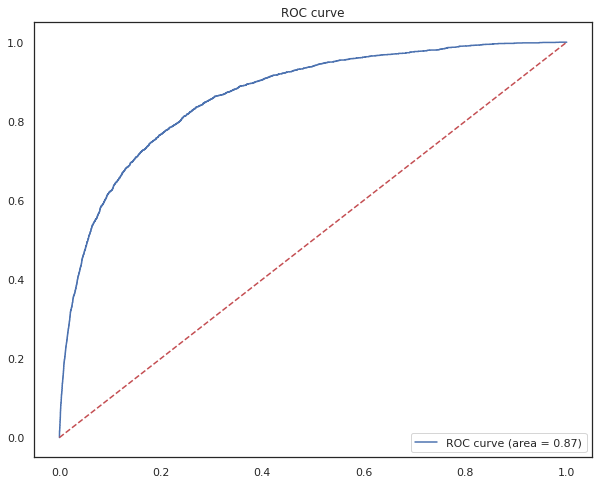

In [55]:
plot_roc(y_test, y_pred_rf)

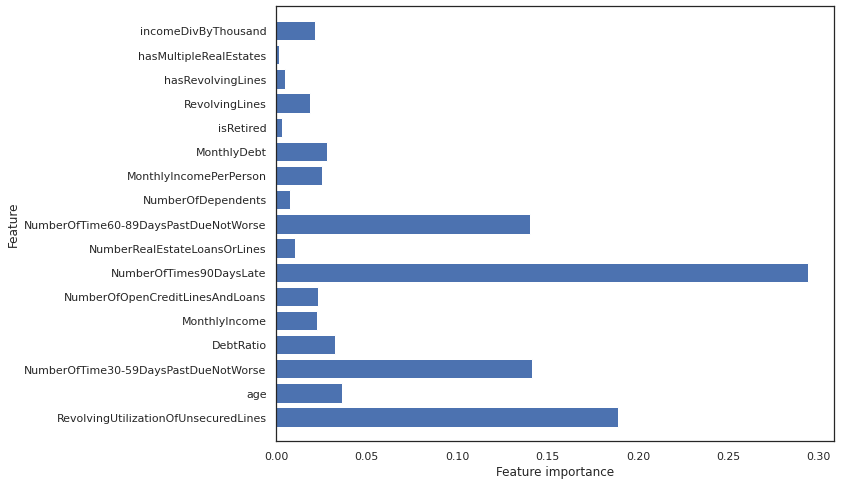

In [56]:
def plot_feature_importances(model):
    plt.figure(figsize=(10,8))
    n_features = X_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), trainDF.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances(best_est_rf)

**3. Light GBM**

In [57]:
#Hyperparameter Tuning
lgbAttributes = lgb.LGBMClassifier(objective='binary', n_jobs=-1, random_state=2020, importance_type='gain')

lgbParameters = {
    'max_depth' : [2,3,4,5],
    'learning_rate': [0.05, 0.1,0.125,0.15],
    'colsample_bytree' : [0.2,0.4,0.6,0.8,1],
    'n_estimators' : [400,500,600,700,800,900],
    'min_split_gain' : [0.15,0.20,0.25,0.3,0.35], #equivalent to gamma in XGBoost
    'subsample': [0.6,0.7,0.8,0.9,1],
    'min_child_weight': [6,7,8,9,10],
    'scale_pos_weight': [10,15,20],
    'min_data_in_leaf' : [100,200,300,400,500,600,700,800,900],
    'num_leaves' : [20,30,40,50,60,70,80,90,100]
}

lgbModel = RandomizedSearchCV(lgbAttributes, param_distributions = lgbParameters, cv = 5, random_state=2020)
lgbModel.fit(X_train,y_train.flatten(),feature_name = trainDF.columns.to_list())

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='gain',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective='binary',
                                            random_state=2020, reg_alpha=0.0,
                                            reg_lambda=0.0, s...
                                        'min_child_weight': [6, 7, 8, 9, 10],
                                        'min_da

In [58]:
bestEstimatorLGB = lgbModel.best_estimator_
bestEstimatorLGB

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.2,
               importance_type='gain', learning_rate=0.125, max_depth=4,
               min_child_samples=20, min_child_weight=9, min_data_in_leaf=500,
               min_split_gain=0.15, n_estimators=500, n_jobs=-1, num_leaves=80,
               objective='binary', random_state=2020, reg_alpha=0.0,
               reg_lambda=0.0, scale_pos_weight=10, silent=True, subsample=0.9,
               subsample_for_bin=200000, subsample_freq=0)

Saving the best estimator from RandomSearchCV

In [59]:
bestEstimatorLGB = lgb.LGBMClassifier(colsample_bytree=0.4, importance_type='gain', max_depth=5,
               min_child_weight=6, min_data_in_leaf=600, min_split_gain=0.25,
               n_estimators=900, num_leaves=50, objective='binary',
               random_state=2020, scale_pos_weight=10, subsample=0.9).fit(X_train,y_train.flatten(),feature_name= trainDF.columns.to_list())

In [60]:
yPredLGB = bestEstimatorLGB.predict_proba(X_test)
yPredLGB = yPredLGB[:,1]
yTestPredLGB = bestEstimatorLGB.predict(X_test)
print(metrics.classification_report(y_test,yTestPredLGB))

              precision    recall  f1-score   support

           0       0.97      0.87      0.92     41862
           1       0.27      0.67      0.38      2968

    accuracy                           0.86     44830
   macro avg       0.62      0.77      0.65     44830
weighted avg       0.93      0.86      0.88     44830



In [61]:
metrics.confusion_matrix(y_test,yTestPredLGB)

array([[36348,  5514],
       [  969,  1999]])

In [62]:
LGBMMetrics = pd.DataFrame({'Model': 'LightGBM', 
                            'MSE': round(metrics.mean_squared_error(y_test, yTestPredLGB)*100,2),
                            'RMSE' : round(np.sqrt(metrics.mean_squared_error(y_test, yTestPredLGB)*100),2),
                            'MAE' : round(metrics.mean_absolute_error(y_test, yTestPredLGB)*100,2),
                            'MSLE' : round(metrics.mean_squared_log_error(y_test, yTestPredLGB)*100,2), 
                            'RMSLE' : round(np.sqrt(metrics.mean_squared_log_error(y_test, yTestPredLGB)*100),2),
                            'Accuracy Train' : round(bestEstimatorLGB.score(X_train, y_train) * 100,2),
                            'Accuracy Test' : round(bestEstimatorLGB.score(X_test, y_test) * 100,2),
                            'F-Beta Score (β=2)' : round(metrics.fbeta_score(y_test, yTestPredLGB, beta=2)*100,2)},index=[1])

LGBMMetrics

,Model,MSE,RMSE,MAE,MSLE,RMSLE,Accuracy Train,Accuracy Test,F-Beta Score (β=2)
1,LightGBM,14.46,3.8,14.46,6.95,2.64,86.48,85.54,51.56


0.8615110314328907


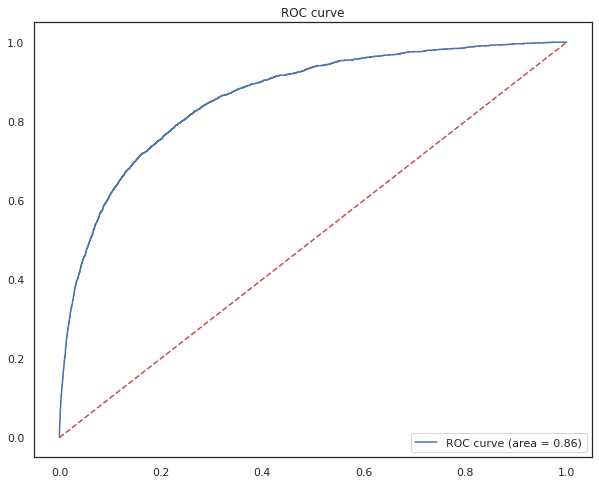

In [63]:
plot_roc(y_test, yPredLGB)

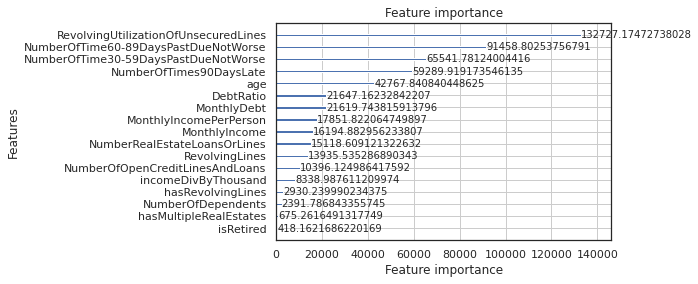

In [64]:
#FEATURE IMPORTANCE
lgb.plot_importance(bestEstimatorLGB, importance_type='gain')

**4. XGBoost**

In [65]:
#Hyperparameter Tuning
xgbAttribute = xgs.XGBClassifier(tree_method='gpu_hist',n_jobs=-1, gpu_id=0)
xgbParameters = {
    'max_depth' : [2,3,4,5,6,7,8],
    'learning_rate':[0.05,0.1,0.125,0.15],
    'colsample_bytree' : [0.2,0.4,0.6,0.8,1],
    'n_estimators' : [400,500,600,700,800,900],
    'gamma':[0.15,0.20,0.25,0.3,0.35],
    'subsample': [0.6,0.7,0.8,0.9,1],
    'min_child_weight': [6,7,8,9,10],
    'scale_pos_weight': [10,15,20]
    
}

xgbModel = RandomizedSearchCV(xgbAttribute, param_distributions = xgbParameters, cv = 5, random_state=2020)
xgbModel.fit(X_train,y_train.flatten())

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           gpu_id=0, learning_rate=0.1,
                                           max_delta_step=0, max_depth=3,
                                           min_child_weight=1, missing=None,
                                           n_estimators=100, n_jobs=-1,
                                           nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_l...
                   param_distributions={'colsample_bytree': [0.2, 0.4, 0.6, 0.8,
                                                     

In [66]:
bestEstimatorXGB = xgbModel.best_estimator_
bestEstimatorXGB

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.25, gpu_id=0,
              learning_rate=0.125, max_delta_step=0, max_depth=5,
              min_child_weight=9, missing=None, n_estimators=800, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

In [67]:
#Setting the best estimator from RandomizedSearchCV
bestEstimatorXGB = xgs.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.25, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.125, max_delta_step=0, max_depth=5,
              min_child_weight=9,
              monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
              n_estimators=800, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=10, subsample=1,
              tree_method='gpu_hist', validate_parameters=1).fit(X_train,y_train.flatten())

In [68]:
yPredXGB = bestEstimatorXGB.predict_proba(X_test)
yPredXGB = yPredXGB[:,1]

yTestPredXGB = bestEstimatorXGB.predict(X_test)
print(metrics.classification_report(y_test,yTestPredXGB))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93     41862
           1       0.28      0.62      0.39      2968

    accuracy                           0.87     44830
   macro avg       0.63      0.76      0.66     44830
weighted avg       0.93      0.87      0.89     44830



In [69]:
metrics.confusion_matrix(y_test,yTestPredXGB)

array([[37184,  4678],
       [ 1117,  1851]])

In [70]:
XGBMetrics = pd.DataFrame({'Model': 'XGBoost', 
                            'MSE': round(metrics.mean_squared_error(y_test, yTestPredXGB)*100,2),
                            'RMSE' : round(np.sqrt(metrics.mean_squared_error(y_test, yTestPredXGB)*100),2),
                            'MAE' : round(metrics.mean_absolute_error(y_test, yTestPredXGB)*100,2),
                            'MSLE' : round(metrics.mean_squared_log_error(y_test, yTestPredXGB)*100,2), 
                            'RMSLE' : round(np.sqrt(metrics.mean_squared_log_error(y_test, yTestPredXGB)*100),2),
                            'Accuracy Train' : round(bestEstimatorLGB.score(X_train, y_train) * 100,2),
                            'Accuracy Test' : round(bestEstimatorLGB.score(X_test, y_test) * 100,2),
                            'F-Beta Score (β=2)' : round(metrics.fbeta_score(y_test, yTestPredXGB, beta=2)*100,2)},index=[2])

XGBMetrics

,Model,MSE,RMSE,MAE,MSLE,RMSLE,Accuracy Train,Accuracy Test,F-Beta Score (β=2)
2,XGBoost,12.93,3.6,12.93,6.21,2.49,86.48,85.54,50.3


0.8553278228967184


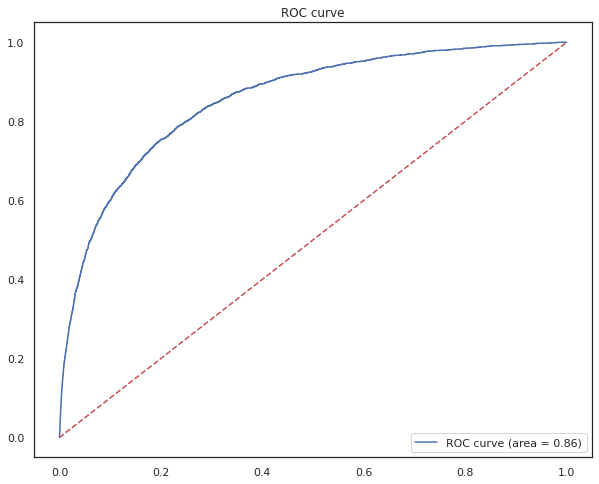

In [71]:
plot_roc(y_test, yPredXGB)

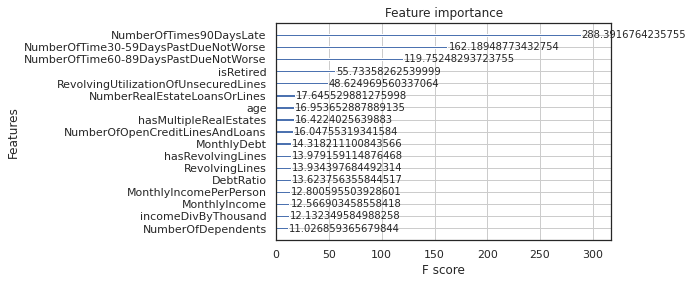

In [72]:
#FEATURE IMPORTANCE
bestEstimatorXGB.get_booster().feature_names = trainDF.columns.to_list()
xgs.plot_importance(bestEstimatorXGB, importance_type='gain')

**Conclusions:**


*   We tested four different models out of which Light GBM performed best in terms of ROC-AUC metric.
*   There is still a scope of more feature engineering in the dataset and more models can be tested.
*   The tested models in this notebook also provided great performance on unseen Kaggle test dataset.



